In [1]:
# Install the professional diffusion library
!pip install denoising-diffusion-pytorch -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.7/83.7 kB 4.2 MB/s eta 0:00:00


In [2]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from denoising_diffusion_pytorch.classifier_free_guidance import Unet, GaussianDiffusion

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMAGE_SIZE = 128  # Reduced from 256 to save memory
NUM_CLASSES = 4   # HGC, LGC, NST, NTL
TIMESTEPS = 1000
BATCH_SIZE = 4    # Reduced from 16 to avoid OOM
EPOCHS = 200

LABEL_MAP = {"HGC": 0, "LGC": 1, "NST": 2, "NTL": 3}
print(f"Using device: {DEVICE}")

# Clear cache if using GPU
if DEVICE == "cuda":
    torch.cuda.empty_cache()

Using device: cuda


In [4]:
# Load and prepare data
TRAIN_CSV = "/kaggle/input/ebt-dataset/train.csv"
train_df = pd.read_csv(TRAIN_CSV)
train_df["label"] = train_df["tissue type"].map(LABEL_MAP)
train_df = train_df[["HLY", "label"]].dropna().reset_index(drop=True)
train_df["label"] = train_df["label"].astype(int)

print("Rows:", len(train_df))
print(train_df["label"].value_counts().sort_index())

Rows: 1224
label
0    309
1    482
2    346
3     87
Name: count, dtype: int64


In [5]:
class BladderDataset(Dataset):
    def __init__(self, df, image_size=256):
        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["HLY"]
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found: {img_path}")
        
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        label = int(self.df.iloc[idx]["label"])
        return image, label

dataset = BladderDataset(train_df, IMAGE_SIZE)
print(f"Dataset size: {len(dataset)}")

Dataset size: 1224


In [6]:
# Create the Unet with classifier-free guidance (smaller architecture)
model = Unet(
    dim=32,  # Reduced from 64 to save memory
    num_classes=NUM_CLASSES,
    cond_drop_prob=0.1,  # 10% of time train unconditionally (for classifier-free guidance)
    dim_mults=(1, 2, 4),  # Reduced from (1, 2, 4, 8) to save memory
    channels=3,
    attn_dim_head=32,
    attn_heads=4
).to(DEVICE)

# Wrap in GaussianDiffusion
diffusion = GaussianDiffusion(
    model,
    image_size=IMAGE_SIZE,
    timesteps=TIMESTEPS,
    sampling_timesteps=250,  # Faster sampling with DDIM
    objective='pred_v',  # v-parameterization (better than noise prediction)
    beta_schedule='cosine',  # Cosine schedule works better than linear
    min_snr_loss_weight=True,  # Improves training stability
    min_snr_gamma=5
).to(DEVICE)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 2,915,619


In [7]:
# Training loop
from torch.utils.data import DataLoader
from tqdm import tqdm

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=False)
optimizer = torch.optim.AdamW(diffusion.parameters(), lr=1e-4)

loss_history = []

for epoch in range(EPOCHS):
    diffusion.train()
    epoch_losses = []
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    for images, labels in pbar:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # Forward pass - the library handles everything internally
        loss = diffusion(images, classes=labels)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(diffusion.parameters(), 1.0)
        optimizer.step()
        
        epoch_losses.append(loss.item())
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})
        
        # Clear cache periodically to avoid memory buildup
        if DEVICE == "cuda":
            torch.cuda.empty_cache()
    
    avg_loss = sum(epoch_losses) / len(epoch_losses)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{EPOCHS} - Avg Loss: {avg_loss:.4f}")

# Save final model
torch.save(diffusion.state_dict(), "/kaggle/working/diffusion_final.pth")
print("Training complete!")

Epoch 1/200: 100%|██████████| 306/306 [00:49<00:00,  6.18it/s, loss=0.0530]


Epoch 1/200 - Avg Loss: 0.0795


Epoch 2/200: 100%|██████████| 306/306 [00:48<00:00,  6.34it/s, loss=0.0209]


Epoch 2/200 - Avg Loss: 0.0264


Epoch 3/200: 100%|██████████| 306/306 [00:48<00:00,  6.32it/s, loss=0.0258]


Epoch 3/200 - Avg Loss: 0.0208


Epoch 4/200: 100%|██████████| 306/306 [00:48<00:00,  6.35it/s, loss=0.0245]


Epoch 4/200 - Avg Loss: 0.0168


Epoch 5/200: 100%|██████████| 306/306 [00:48<00:00,  6.36it/s, loss=0.0186]


Epoch 5/200 - Avg Loss: 0.0139


Epoch 6/200: 100%|██████████| 306/306 [00:48<00:00,  6.35it/s, loss=0.0165]


Epoch 6/200 - Avg Loss: 0.0127


Epoch 7/200: 100%|██████████| 306/306 [00:48<00:00,  6.37it/s, loss=0.0105]


Epoch 7/200 - Avg Loss: 0.0113


Epoch 8/200: 100%|██████████| 306/306 [00:48<00:00,  6.35it/s, loss=0.0164]


Epoch 8/200 - Avg Loss: 0.0107


Epoch 9/200: 100%|██████████| 306/306 [00:48<00:00,  6.35it/s, loss=0.0112]


Epoch 9/200 - Avg Loss: 0.0098


Epoch 10/200: 100%|██████████| 306/306 [00:48<00:00,  6.35it/s, loss=0.0033]


Epoch 10/200 - Avg Loss: 0.0083


Epoch 11/200: 100%|██████████| 306/306 [00:48<00:00,  6.36it/s, loss=0.0082]


Epoch 11/200 - Avg Loss: 0.0086


Epoch 12/200: 100%|██████████| 306/306 [00:48<00:00,  6.35it/s, loss=0.0041]


Epoch 12/200 - Avg Loss: 0.0080


Epoch 13/200: 100%|██████████| 306/306 [00:48<00:00,  6.35it/s, loss=0.0095]


Epoch 13/200 - Avg Loss: 0.0077


Epoch 14/200: 100%|██████████| 306/306 [00:48<00:00,  6.35it/s, loss=0.0078]


Epoch 14/200 - Avg Loss: 0.0078


Epoch 15/200: 100%|██████████| 306/306 [00:48<00:00,  6.36it/s, loss=0.0127]


Epoch 15/200 - Avg Loss: 0.0069


Epoch 16/200: 100%|██████████| 306/306 [00:48<00:00,  6.35it/s, loss=0.0110]


Epoch 16/200 - Avg Loss: 0.0070


Epoch 17/200: 100%|██████████| 306/306 [00:48<00:00,  6.31it/s, loss=0.0036]


Epoch 17/200 - Avg Loss: 0.0067


Epoch 18/200: 100%|██████████| 306/306 [00:48<00:00,  6.29it/s, loss=0.0089]


Epoch 18/200 - Avg Loss: 0.0063


Epoch 19/200: 100%|██████████| 306/306 [00:48<00:00,  6.31it/s, loss=0.0024]


Epoch 19/200 - Avg Loss: 0.0065


Epoch 20/200: 100%|██████████| 306/306 [00:48<00:00,  6.32it/s, loss=0.0067]


Epoch 20/200 - Avg Loss: 0.0066


Epoch 21/200: 100%|██████████| 306/306 [00:48<00:00,  6.28it/s, loss=0.0048]


Epoch 21/200 - Avg Loss: 0.0064


Epoch 22/200: 100%|██████████| 306/306 [00:48<00:00,  6.30it/s, loss=0.0050]


Epoch 22/200 - Avg Loss: 0.0061


Epoch 23/200: 100%|██████████| 306/306 [00:48<00:00,  6.34it/s, loss=0.0085]


Epoch 23/200 - Avg Loss: 0.0059


Epoch 24/200: 100%|██████████| 306/306 [00:48<00:00,  6.33it/s, loss=0.0097]


Epoch 24/200 - Avg Loss: 0.0063


Epoch 25/200: 100%|██████████| 306/306 [00:48<00:00,  6.36it/s, loss=0.0053]


Epoch 25/200 - Avg Loss: 0.0061


Epoch 26/200: 100%|██████████| 306/306 [00:48<00:00,  6.34it/s, loss=0.0063]


Epoch 26/200 - Avg Loss: 0.0057


Epoch 27/200: 100%|██████████| 306/306 [00:48<00:00,  6.35it/s, loss=0.0045]


Epoch 27/200 - Avg Loss: 0.0056


Epoch 28/200: 100%|██████████| 306/306 [00:48<00:00,  6.36it/s, loss=0.0050]


Epoch 28/200 - Avg Loss: 0.0056


Epoch 29/200: 100%|██████████| 306/306 [00:48<00:00,  6.36it/s, loss=0.0040]


Epoch 29/200 - Avg Loss: 0.0059


Epoch 30/200: 100%|██████████| 306/306 [00:48<00:00,  6.37it/s, loss=0.0035]


Epoch 30/200 - Avg Loss: 0.0054


Epoch 31/200: 100%|██████████| 306/306 [00:48<00:00,  6.35it/s, loss=0.0075]


Epoch 31/200 - Avg Loss: 0.0054


Epoch 32/200: 100%|██████████| 306/306 [00:48<00:00,  6.35it/s, loss=0.0056]


Epoch 32/200 - Avg Loss: 0.0056


Epoch 33/200: 100%|██████████| 306/306 [00:48<00:00,  6.36it/s, loss=0.0030]


Epoch 33/200 - Avg Loss: 0.0053


Epoch 34/200: 100%|██████████| 306/306 [00:48<00:00,  6.37it/s, loss=0.0044]


Epoch 34/200 - Avg Loss: 0.0055


Epoch 35/200: 100%|██████████| 306/306 [00:48<00:00,  6.35it/s, loss=0.0086]


Epoch 35/200 - Avg Loss: 0.0053


Epoch 36/200: 100%|██████████| 306/306 [00:48<00:00,  6.37it/s, loss=0.0071]


Epoch 36/200 - Avg Loss: 0.0054


Epoch 37/200: 100%|██████████| 306/306 [00:48<00:00,  6.37it/s, loss=0.0025]


Epoch 37/200 - Avg Loss: 0.0052


Epoch 38/200: 100%|██████████| 306/306 [00:48<00:00,  6.35it/s, loss=0.0047]


Epoch 38/200 - Avg Loss: 0.0051


Epoch 39/200: 100%|██████████| 306/306 [00:48<00:00,  6.37it/s, loss=0.0043]


Epoch 39/200 - Avg Loss: 0.0052


Epoch 40/200: 100%|██████████| 306/306 [00:48<00:00,  6.36it/s, loss=0.0085]


Epoch 40/200 - Avg Loss: 0.0049


Epoch 41/200: 100%|██████████| 306/306 [00:48<00:00,  6.35it/s, loss=0.0057]


Epoch 41/200 - Avg Loss: 0.0052


Epoch 42/200: 100%|██████████| 306/306 [00:48<00:00,  6.34it/s, loss=0.0041]


Epoch 42/200 - Avg Loss: 0.0051


Epoch 43/200: 100%|██████████| 306/306 [00:48<00:00,  6.36it/s, loss=0.0063]


Epoch 43/200 - Avg Loss: 0.0050


Epoch 44/200: 100%|██████████| 306/306 [00:48<00:00,  6.34it/s, loss=0.0047]


Epoch 44/200 - Avg Loss: 0.0048


Epoch 45/200: 100%|██████████| 306/306 [00:48<00:00,  6.34it/s, loss=0.0082]


Epoch 45/200 - Avg Loss: 0.0050


Epoch 46/200: 100%|██████████| 306/306 [00:48<00:00,  6.37it/s, loss=0.0062]


Epoch 46/200 - Avg Loss: 0.0046


Epoch 47/200: 100%|██████████| 306/306 [00:48<00:00,  6.28it/s, loss=0.0037]


Epoch 47/200 - Avg Loss: 0.0049


Epoch 48/200: 100%|██████████| 306/306 [00:48<00:00,  6.29it/s, loss=0.0082]


Epoch 48/200 - Avg Loss: 0.0049


Epoch 49/200: 100%|██████████| 306/306 [00:48<00:00,  6.31it/s, loss=0.0069]


Epoch 49/200 - Avg Loss: 0.0049


Epoch 50/200: 100%|██████████| 306/306 [00:48<00:00,  6.33it/s, loss=0.0036]


Epoch 50/200 - Avg Loss: 0.0049


Epoch 51/200: 100%|██████████| 306/306 [00:48<00:00,  6.33it/s, loss=0.0061]


Epoch 51/200 - Avg Loss: 0.0049


Epoch 52/200: 100%|██████████| 306/306 [00:48<00:00,  6.33it/s, loss=0.0017]


Epoch 52/200 - Avg Loss: 0.0048


Epoch 53/200: 100%|██████████| 306/306 [00:48<00:00,  6.35it/s, loss=0.0041]


Epoch 53/200 - Avg Loss: 0.0049


Epoch 54/200: 100%|██████████| 306/306 [00:48<00:00,  6.35it/s, loss=0.0025]


Epoch 54/200 - Avg Loss: 0.0049


Epoch 55/200: 100%|██████████| 306/306 [00:48<00:00,  6.34it/s, loss=0.0056]


Epoch 55/200 - Avg Loss: 0.0047


Epoch 56/200: 100%|██████████| 306/306 [00:48<00:00,  6.35it/s, loss=0.0103]


Epoch 56/200 - Avg Loss: 0.0047


Epoch 57/200: 100%|██████████| 306/306 [00:48<00:00,  6.35it/s, loss=0.0047]


Epoch 57/200 - Avg Loss: 0.0048


Epoch 58/200: 100%|██████████| 306/306 [00:48<00:00,  6.36it/s, loss=0.0060]


Epoch 58/200 - Avg Loss: 0.0045


Epoch 59/200: 100%|██████████| 306/306 [00:48<00:00,  6.36it/s, loss=0.0045]


Epoch 59/200 - Avg Loss: 0.0045


Epoch 60/200: 100%|██████████| 306/306 [00:47<00:00,  6.43it/s, loss=0.0061]


Epoch 60/200 - Avg Loss: 0.0048


Epoch 61/200: 100%|██████████| 306/306 [00:47<00:00,  6.41it/s, loss=0.0034]


Epoch 61/200 - Avg Loss: 0.0046


Epoch 62/200: 100%|██████████| 306/306 [00:47<00:00,  6.42it/s, loss=0.0065]


Epoch 62/200 - Avg Loss: 0.0048


Epoch 63/200: 100%|██████████| 306/306 [00:47<00:00,  6.41it/s, loss=0.0010]


Epoch 63/200 - Avg Loss: 0.0048


Epoch 64/200: 100%|██████████| 306/306 [00:47<00:00,  6.42it/s, loss=0.0058]


Epoch 64/200 - Avg Loss: 0.0045


Epoch 65/200: 100%|██████████| 306/306 [00:48<00:00,  6.36it/s, loss=0.0054]


Epoch 65/200 - Avg Loss: 0.0046


Epoch 66/200: 100%|██████████| 306/306 [00:48<00:00,  6.30it/s, loss=0.0069]


Epoch 66/200 - Avg Loss: 0.0046


Epoch 67/200: 100%|██████████| 306/306 [00:47<00:00,  6.42it/s, loss=0.0044]


Epoch 67/200 - Avg Loss: 0.0045


Epoch 68/200: 100%|██████████| 306/306 [00:47<00:00,  6.41it/s, loss=0.0056]


Epoch 68/200 - Avg Loss: 0.0045


Epoch 69/200: 100%|██████████| 306/306 [00:47<00:00,  6.41it/s, loss=0.0031]


Epoch 69/200 - Avg Loss: 0.0045


Epoch 70/200: 100%|██████████| 306/306 [00:47<00:00,  6.41it/s, loss=0.0034]


Epoch 70/200 - Avg Loss: 0.0044


Epoch 71/200: 100%|██████████| 306/306 [00:47<00:00,  6.40it/s, loss=0.0059]


Epoch 71/200 - Avg Loss: 0.0048


Epoch 72/200: 100%|██████████| 306/306 [00:47<00:00,  6.43it/s, loss=0.0040]


Epoch 72/200 - Avg Loss: 0.0046


Epoch 73/200: 100%|██████████| 306/306 [00:47<00:00,  6.41it/s, loss=0.0072]


Epoch 73/200 - Avg Loss: 0.0044


Epoch 74/200: 100%|██████████| 306/306 [00:48<00:00,  6.37it/s, loss=0.0016]


Epoch 74/200 - Avg Loss: 0.0044


Epoch 75/200: 100%|██████████| 306/306 [00:48<00:00,  6.35it/s, loss=0.0031]


Epoch 75/200 - Avg Loss: 0.0044


Epoch 76/200: 100%|██████████| 306/306 [00:48<00:00,  6.34it/s, loss=0.0063]


Epoch 76/200 - Avg Loss: 0.0045


Epoch 77/200: 100%|██████████| 306/306 [00:47<00:00,  6.41it/s, loss=0.0034]


Epoch 77/200 - Avg Loss: 0.0043


Epoch 78/200: 100%|██████████| 306/306 [00:47<00:00,  6.41it/s, loss=0.0061]


Epoch 78/200 - Avg Loss: 0.0044


Epoch 79/200: 100%|██████████| 306/306 [00:47<00:00,  6.41it/s, loss=0.0025]


Epoch 79/200 - Avg Loss: 0.0043


Epoch 80/200: 100%|██████████| 306/306 [00:47<00:00,  6.42it/s, loss=0.0030]


Epoch 80/200 - Avg Loss: 0.0043


Epoch 81/200: 100%|██████████| 306/306 [00:47<00:00,  6.42it/s, loss=0.0071]


Epoch 81/200 - Avg Loss: 0.0044


Epoch 82/200: 100%|██████████| 306/306 [00:47<00:00,  6.43it/s, loss=0.0028]


Epoch 82/200 - Avg Loss: 0.0043


Epoch 83/200: 100%|██████████| 306/306 [00:47<00:00,  6.42it/s, loss=0.0047]


Epoch 83/200 - Avg Loss: 0.0044


Epoch 84/200: 100%|██████████| 306/306 [00:47<00:00,  6.44it/s, loss=0.0026]


Epoch 84/200 - Avg Loss: 0.0041


Epoch 85/200: 100%|██████████| 306/306 [00:47<00:00,  6.40it/s, loss=0.0062]


Epoch 85/200 - Avg Loss: 0.0044


Epoch 86/200: 100%|██████████| 306/306 [00:47<00:00,  6.42it/s, loss=0.0065]


Epoch 86/200 - Avg Loss: 0.0044


Epoch 87/200: 100%|██████████| 306/306 [00:47<00:00,  6.41it/s, loss=0.0084]


Epoch 87/200 - Avg Loss: 0.0043


Epoch 88/200: 100%|██████████| 306/306 [00:47<00:00,  6.43it/s, loss=0.0020]


Epoch 88/200 - Avg Loss: 0.0044


Epoch 89/200: 100%|██████████| 306/306 [00:47<00:00,  6.43it/s, loss=0.0035]


Epoch 89/200 - Avg Loss: 0.0042


Epoch 90/200: 100%|██████████| 306/306 [00:47<00:00,  6.42it/s, loss=0.0061]


Epoch 90/200 - Avg Loss: 0.0041


Epoch 91/200: 100%|██████████| 306/306 [00:47<00:00,  6.40it/s, loss=0.0052]


Epoch 91/200 - Avg Loss: 0.0044


Epoch 92/200: 100%|██████████| 306/306 [00:47<00:00,  6.41it/s, loss=0.0049]


Epoch 92/200 - Avg Loss: 0.0041


Epoch 93/200: 100%|██████████| 306/306 [00:47<00:00,  6.42it/s, loss=0.0055]


Epoch 93/200 - Avg Loss: 0.0042


Epoch 94/200: 100%|██████████| 306/306 [00:47<00:00,  6.40it/s, loss=0.0032]


Epoch 94/200 - Avg Loss: 0.0043


Epoch 95/200: 100%|██████████| 306/306 [00:47<00:00,  6.39it/s, loss=0.0056]


Epoch 95/200 - Avg Loss: 0.0042


Epoch 96/200: 100%|██████████| 306/306 [00:47<00:00,  6.42it/s, loss=0.0067]


Epoch 96/200 - Avg Loss: 0.0041


Epoch 97/200: 100%|██████████| 306/306 [00:47<00:00,  6.42it/s, loss=0.0037]


Epoch 97/200 - Avg Loss: 0.0042


Epoch 98/200: 100%|██████████| 306/306 [00:47<00:00,  6.42it/s, loss=0.0032]


Epoch 98/200 - Avg Loss: 0.0044


Epoch 99/200: 100%|██████████| 306/306 [00:47<00:00,  6.39it/s, loss=0.0069]


Epoch 99/200 - Avg Loss: 0.0042


Epoch 100/200: 100%|██████████| 306/306 [00:48<00:00,  6.35it/s, loss=0.0076]


Epoch 100/200 - Avg Loss: 0.0043


Epoch 101/200: 100%|██████████| 306/306 [00:47<00:00,  6.38it/s, loss=0.0063]


Epoch 101/200 - Avg Loss: 0.0042


Epoch 102/200: 100%|██████████| 306/306 [00:48<00:00,  6.36it/s, loss=0.0085]


Epoch 102/200 - Avg Loss: 0.0042


Epoch 103/200: 100%|██████████| 306/306 [00:47<00:00,  6.39it/s, loss=0.0023]


Epoch 103/200 - Avg Loss: 0.0041


Epoch 104/200: 100%|██████████| 306/306 [00:47<00:00,  6.39it/s, loss=0.0025]


Epoch 104/200 - Avg Loss: 0.0040


Epoch 105/200: 100%|██████████| 306/306 [00:47<00:00,  6.41it/s, loss=0.0064]


Epoch 105/200 - Avg Loss: 0.0041


Epoch 106/200: 100%|██████████| 306/306 [00:47<00:00,  6.39it/s, loss=0.0053]


Epoch 106/200 - Avg Loss: 0.0040


Epoch 107/200: 100%|██████████| 306/306 [00:47<00:00,  6.39it/s, loss=0.0031]


Epoch 107/200 - Avg Loss: 0.0040


Epoch 108/200: 100%|██████████| 306/306 [00:48<00:00,  6.36it/s, loss=0.0024]


Epoch 108/200 - Avg Loss: 0.0041


Epoch 109/200: 100%|██████████| 306/306 [00:48<00:00,  6.36it/s, loss=0.0021]


Epoch 109/200 - Avg Loss: 0.0040


Epoch 110/200: 100%|██████████| 306/306 [00:48<00:00,  6.35it/s, loss=0.0057]


Epoch 110/200 - Avg Loss: 0.0041


Epoch 111/200: 100%|██████████| 306/306 [00:48<00:00,  6.35it/s, loss=0.0016]


Epoch 111/200 - Avg Loss: 0.0042


Epoch 112/200: 100%|██████████| 306/306 [00:47<00:00,  6.38it/s, loss=0.0047]


Epoch 112/200 - Avg Loss: 0.0039


Epoch 113/200: 100%|██████████| 306/306 [00:48<00:00,  6.35it/s, loss=0.0049]


Epoch 113/200 - Avg Loss: 0.0042


Epoch 114/200: 100%|██████████| 306/306 [00:48<00:00,  6.37it/s, loss=0.0027]


Epoch 114/200 - Avg Loss: 0.0042


Epoch 115/200: 100%|██████████| 306/306 [00:48<00:00,  6.35it/s, loss=0.0023]


Epoch 115/200 - Avg Loss: 0.0041


Epoch 116/200: 100%|██████████| 306/306 [00:48<00:00,  6.36it/s, loss=0.0059]


Epoch 116/200 - Avg Loss: 0.0042


Epoch 117/200: 100%|██████████| 306/306 [00:48<00:00,  6.35it/s, loss=0.0042]


Epoch 117/200 - Avg Loss: 0.0041


Epoch 118/200: 100%|██████████| 306/306 [00:48<00:00,  6.36it/s, loss=0.0046]


Epoch 118/200 - Avg Loss: 0.0041


Epoch 119/200: 100%|██████████| 306/306 [00:48<00:00,  6.35it/s, loss=0.0055]


Epoch 119/200 - Avg Loss: 0.0041


Epoch 120/200: 100%|██████████| 306/306 [00:48<00:00,  6.35it/s, loss=0.0058]


Epoch 120/200 - Avg Loss: 0.0043


Epoch 121/200: 100%|██████████| 306/306 [00:48<00:00,  6.35it/s, loss=0.0031]


Epoch 121/200 - Avg Loss: 0.0041


Epoch 122/200: 100%|██████████| 306/306 [00:47<00:00,  6.38it/s, loss=0.0022]


Epoch 122/200 - Avg Loss: 0.0041


Epoch 123/200: 100%|██████████| 306/306 [00:47<00:00,  6.38it/s, loss=0.0064]


Epoch 123/200 - Avg Loss: 0.0041


Epoch 124/200: 100%|██████████| 306/306 [00:48<00:00,  6.36it/s, loss=0.0033]


Epoch 124/200 - Avg Loss: 0.0041


Epoch 125/200: 100%|██████████| 306/306 [00:48<00:00,  6.36it/s, loss=0.0040]


Epoch 125/200 - Avg Loss: 0.0040


Epoch 126/200: 100%|██████████| 306/306 [00:48<00:00,  6.35it/s, loss=0.0050]


Epoch 126/200 - Avg Loss: 0.0041


Epoch 127/200: 100%|██████████| 306/306 [00:47<00:00,  6.38it/s, loss=0.0058]


Epoch 127/200 - Avg Loss: 0.0039


Epoch 128/200: 100%|██████████| 306/306 [00:48<00:00,  6.37it/s, loss=0.0078]


Epoch 128/200 - Avg Loss: 0.0042


Epoch 129/200: 100%|██████████| 306/306 [00:48<00:00,  6.36it/s, loss=0.0060]


Epoch 129/200 - Avg Loss: 0.0040


Epoch 130/200: 100%|██████████| 306/306 [00:48<00:00,  6.36it/s, loss=0.0007]


Epoch 130/200 - Avg Loss: 0.0039


Epoch 131/200: 100%|██████████| 306/306 [00:48<00:00,  6.35it/s, loss=0.0015]


Epoch 131/200 - Avg Loss: 0.0040


Epoch 132/200: 100%|██████████| 306/306 [00:48<00:00,  6.33it/s, loss=0.0049]


Epoch 132/200 - Avg Loss: 0.0039


Epoch 133/200: 100%|██████████| 306/306 [00:48<00:00,  6.37it/s, loss=0.0033]


Epoch 133/200 - Avg Loss: 0.0040


Epoch 134/200: 100%|██████████| 306/306 [00:48<00:00,  6.36it/s, loss=0.0073]


Epoch 134/200 - Avg Loss: 0.0040


Epoch 135/200: 100%|██████████| 306/306 [00:48<00:00,  6.36it/s, loss=0.0060]


Epoch 135/200 - Avg Loss: 0.0040


Epoch 136/200: 100%|██████████| 306/306 [00:47<00:00,  6.38it/s, loss=0.0050]


Epoch 136/200 - Avg Loss: 0.0038


Epoch 137/200: 100%|██████████| 306/306 [00:47<00:00,  6.38it/s, loss=0.0006]


Epoch 137/200 - Avg Loss: 0.0041


Epoch 138/200: 100%|██████████| 306/306 [00:48<00:00,  6.37it/s, loss=0.0045]


Epoch 138/200 - Avg Loss: 0.0040


Epoch 139/200: 100%|██████████| 306/306 [00:47<00:00,  6.38it/s, loss=0.0051]


Epoch 139/200 - Avg Loss: 0.0040


Epoch 140/200: 100%|██████████| 306/306 [00:47<00:00,  6.38it/s, loss=0.0045]


Epoch 140/200 - Avg Loss: 0.0041


Epoch 141/200: 100%|██████████| 306/306 [00:47<00:00,  6.38it/s, loss=0.0038]


Epoch 141/200 - Avg Loss: 0.0039


Epoch 142/200: 100%|██████████| 306/306 [00:48<00:00,  6.37it/s, loss=0.0039]


Epoch 142/200 - Avg Loss: 0.0041


Epoch 143/200: 100%|██████████| 306/306 [00:48<00:00,  6.37it/s, loss=0.0035]


Epoch 143/200 - Avg Loss: 0.0039


Epoch 144/200: 100%|██████████| 306/306 [00:48<00:00,  6.36it/s, loss=0.0043]


Epoch 144/200 - Avg Loss: 0.0041


Epoch 145/200: 100%|██████████| 306/306 [00:48<00:00,  6.37it/s, loss=0.0027]


Epoch 145/200 - Avg Loss: 0.0038


Epoch 146/200: 100%|██████████| 306/306 [00:48<00:00,  6.37it/s, loss=0.0038]


Epoch 146/200 - Avg Loss: 0.0039


Epoch 147/200: 100%|██████████| 306/306 [00:47<00:00,  6.39it/s, loss=0.0042]


Epoch 147/200 - Avg Loss: 0.0039


Epoch 148/200: 100%|██████████| 306/306 [00:47<00:00,  6.40it/s, loss=0.0037]


Epoch 148/200 - Avg Loss: 0.0038


Epoch 149/200: 100%|██████████| 306/306 [00:48<00:00,  6.37it/s, loss=0.0058]


Epoch 149/200 - Avg Loss: 0.0040


Epoch 150/200: 100%|██████████| 306/306 [00:47<00:00,  6.39it/s, loss=0.0074]


Epoch 150/200 - Avg Loss: 0.0037


Epoch 151/200: 100%|██████████| 306/306 [00:47<00:00,  6.39it/s, loss=0.0027]


Epoch 151/200 - Avg Loss: 0.0038


Epoch 152/200: 100%|██████████| 306/306 [00:48<00:00,  6.37it/s, loss=0.0055]


Epoch 152/200 - Avg Loss: 0.0040


Epoch 153/200: 100%|██████████| 306/306 [00:47<00:00,  6.39it/s, loss=0.0041]


Epoch 153/200 - Avg Loss: 0.0038


Epoch 154/200: 100%|██████████| 306/306 [00:48<00:00,  6.36it/s, loss=0.0059]


Epoch 154/200 - Avg Loss: 0.0037


Epoch 155/200: 100%|██████████| 306/306 [00:48<00:00,  6.35it/s, loss=0.0033]


Epoch 155/200 - Avg Loss: 0.0040


Epoch 156/200: 100%|██████████| 306/306 [00:48<00:00,  6.37it/s, loss=0.0051]


Epoch 156/200 - Avg Loss: 0.0039


Epoch 157/200: 100%|██████████| 306/306 [00:48<00:00,  6.37it/s, loss=0.0056]


Epoch 157/200 - Avg Loss: 0.0038


Epoch 158/200: 100%|██████████| 306/306 [00:48<00:00,  6.37it/s, loss=0.0034]


Epoch 158/200 - Avg Loss: 0.0037


Epoch 159/200: 100%|██████████| 306/306 [00:48<00:00,  6.35it/s, loss=0.0029]


Epoch 159/200 - Avg Loss: 0.0038


Epoch 160/200: 100%|██████████| 306/306 [00:47<00:00,  6.38it/s, loss=0.0084]


Epoch 160/200 - Avg Loss: 0.0038


Epoch 161/200: 100%|██████████| 306/306 [00:47<00:00,  6.38it/s, loss=0.0024]


Epoch 161/200 - Avg Loss: 0.0039


Epoch 162/200: 100%|██████████| 306/306 [00:48<00:00,  6.34it/s, loss=0.0026]


Epoch 162/200 - Avg Loss: 0.0038


Epoch 163/200: 100%|██████████| 306/306 [00:48<00:00,  6.33it/s, loss=0.0052]


Epoch 163/200 - Avg Loss: 0.0038


Epoch 164/200: 100%|██████████| 306/306 [00:48<00:00,  6.32it/s, loss=0.0032]


Epoch 164/200 - Avg Loss: 0.0038


Epoch 165/200: 100%|██████████| 306/306 [00:48<00:00,  6.33it/s, loss=0.0014]


Epoch 165/200 - Avg Loss: 0.0038


Epoch 166/200: 100%|██████████| 306/306 [00:48<00:00,  6.35it/s, loss=0.0029]


Epoch 166/200 - Avg Loss: 0.0038


Epoch 167/200: 100%|██████████| 306/306 [00:48<00:00,  6.34it/s, loss=0.0025]


Epoch 167/200 - Avg Loss: 0.0037


Epoch 168/200: 100%|██████████| 306/306 [00:48<00:00,  6.37it/s, loss=0.0082]


Epoch 168/200 - Avg Loss: 0.0039


Epoch 169/200: 100%|██████████| 306/306 [00:48<00:00,  6.37it/s, loss=0.0032]


Epoch 169/200 - Avg Loss: 0.0037


Epoch 170/200: 100%|██████████| 306/306 [00:48<00:00,  6.37it/s, loss=0.0019]


Epoch 170/200 - Avg Loss: 0.0037


Epoch 171/200: 100%|██████████| 306/306 [00:48<00:00,  6.35it/s, loss=0.0046]


Epoch 171/200 - Avg Loss: 0.0037


Epoch 172/200: 100%|██████████| 306/306 [00:48<00:00,  6.33it/s, loss=0.0027]


Epoch 172/200 - Avg Loss: 0.0038


Epoch 173/200: 100%|██████████| 306/306 [00:48<00:00,  6.36it/s, loss=0.0033]


Epoch 173/200 - Avg Loss: 0.0038


Epoch 174/200: 100%|██████████| 306/306 [00:48<00:00,  6.33it/s, loss=0.0041]


Epoch 174/200 - Avg Loss: 0.0038


Epoch 175/200: 100%|██████████| 306/306 [00:47<00:00,  6.38it/s, loss=0.0071]


Epoch 175/200 - Avg Loss: 0.0038


Epoch 176/200: 100%|██████████| 306/306 [00:48<00:00,  6.37it/s, loss=0.0023]


Epoch 176/200 - Avg Loss: 0.0037


Epoch 177/200: 100%|██████████| 306/306 [00:47<00:00,  6.38it/s, loss=0.0045]


Epoch 177/200 - Avg Loss: 0.0038


Epoch 178/200: 100%|██████████| 306/306 [00:48<00:00,  6.36it/s, loss=0.0047]


Epoch 178/200 - Avg Loss: 0.0038


Epoch 179/200: 100%|██████████| 306/306 [00:48<00:00,  6.37it/s, loss=0.0033]


Epoch 179/200 - Avg Loss: 0.0038


Epoch 180/200: 100%|██████████| 306/306 [00:48<00:00,  6.36it/s, loss=0.0035]


Epoch 180/200 - Avg Loss: 0.0038


Epoch 181/200: 100%|██████████| 306/306 [00:48<00:00,  6.36it/s, loss=0.0030]


Epoch 181/200 - Avg Loss: 0.0036


Epoch 182/200: 100%|██████████| 306/306 [00:48<00:00,  6.32it/s, loss=0.0032]


Epoch 182/200 - Avg Loss: 0.0038


Epoch 183/200: 100%|██████████| 306/306 [00:48<00:00,  6.36it/s, loss=0.0017]


Epoch 183/200 - Avg Loss: 0.0036


Epoch 184/200: 100%|██████████| 306/306 [00:48<00:00,  6.36it/s, loss=0.0073]


Epoch 184/200 - Avg Loss: 0.0037


Epoch 185/200: 100%|██████████| 306/306 [00:48<00:00,  6.36it/s, loss=0.0046]


Epoch 185/200 - Avg Loss: 0.0039


Epoch 186/200: 100%|██████████| 306/306 [00:47<00:00,  6.38it/s, loss=0.0033]


Epoch 186/200 - Avg Loss: 0.0038


Epoch 187/200: 100%|██████████| 306/306 [00:48<00:00,  6.34it/s, loss=0.0058]


Epoch 187/200 - Avg Loss: 0.0037


Epoch 188/200: 100%|██████████| 306/306 [00:47<00:00,  6.39it/s, loss=0.0052]


Epoch 188/200 - Avg Loss: 0.0038


Epoch 189/200: 100%|██████████| 306/306 [00:48<00:00,  6.37it/s, loss=0.0009]


Epoch 189/200 - Avg Loss: 0.0037


Epoch 190/200: 100%|██████████| 306/306 [00:48<00:00,  6.36it/s, loss=0.0048]


Epoch 190/200 - Avg Loss: 0.0038


Epoch 191/200: 100%|██████████| 306/306 [00:48<00:00,  6.36it/s, loss=0.0035]


Epoch 191/200 - Avg Loss: 0.0037


Epoch 192/200: 100%|██████████| 306/306 [00:48<00:00,  6.34it/s, loss=0.0029]


Epoch 192/200 - Avg Loss: 0.0037


Epoch 193/200: 100%|██████████| 306/306 [00:48<00:00,  6.34it/s, loss=0.0032]


Epoch 193/200 - Avg Loss: 0.0037


Epoch 194/200: 100%|██████████| 306/306 [00:47<00:00,  6.42it/s, loss=0.0022]


Epoch 194/200 - Avg Loss: 0.0038


Epoch 195/200: 100%|██████████| 306/306 [00:47<00:00,  6.41it/s, loss=0.0041]


Epoch 195/200 - Avg Loss: 0.0036


Epoch 196/200: 100%|██████████| 306/306 [00:47<00:00,  6.41it/s, loss=0.0034]


Epoch 196/200 - Avg Loss: 0.0038


Epoch 197/200: 100%|██████████| 306/306 [00:47<00:00,  6.40it/s, loss=0.0030]


Epoch 197/200 - Avg Loss: 0.0037


Epoch 198/200: 100%|██████████| 306/306 [00:47<00:00,  6.39it/s, loss=0.0035]


Epoch 198/200 - Avg Loss: 0.0036


Epoch 199/200: 100%|██████████| 306/306 [00:47<00:00,  6.43it/s, loss=0.0047]


Epoch 199/200 - Avg Loss: 0.0039


Epoch 200/200: 100%|██████████| 306/306 [00:47<00:00,  6.43it/s, loss=0.0052]


Epoch 200/200 - Avg Loss: 0.0036
Training complete!


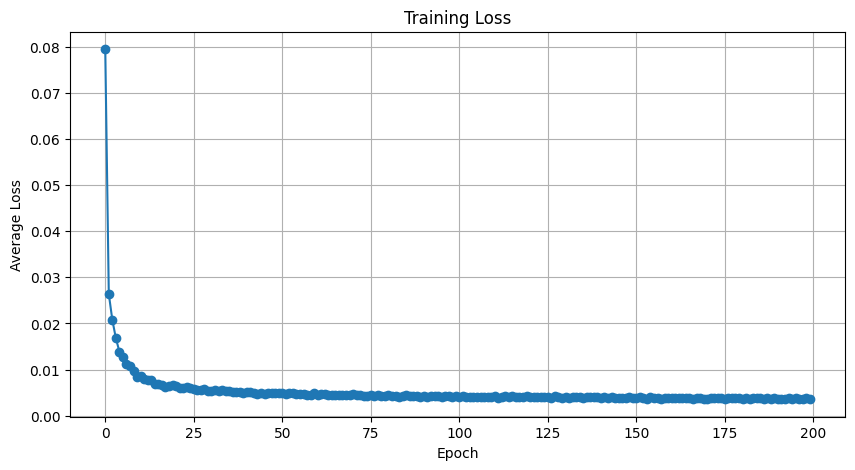

In [8]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(loss_history, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss')
plt.grid(True)
plt.savefig('/kaggle/working/training_loss.png', dpi=150, bbox_inches='tight')
plt.show()

In [9]:
# Load trained model (if restarting kernel)
diffusion.load_state_dict(torch.load("/kaggle/working/diffusion_final.pth"))
diffusion.eval()
print("Model loaded!")

Model loaded!


In [10]:
# Generate samples with classifier-free guidance
# Higher cond_scale = stronger conditioning on class label

class_id = 3  # NTL
num_samples = 40  # Reduced from 40 to avoid OOM during generation

# Clear cache before generation
if DEVICE == "cuda":
    torch.cuda.empty_cache()

# Generate with strong guidance
classes = torch.full((num_samples,), class_id, device=DEVICE, dtype=torch.long)
generated_images = diffusion.sample(
    classes=classes,
    cond_scale=6.0,  # Guidance strength (higher = more class-specific)
    rescaled_phi=0.7
)

print(f"Generated {num_samples} images for class {list(LABEL_MAP.keys())[class_id]}")

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

Generated 40 images for class NTL


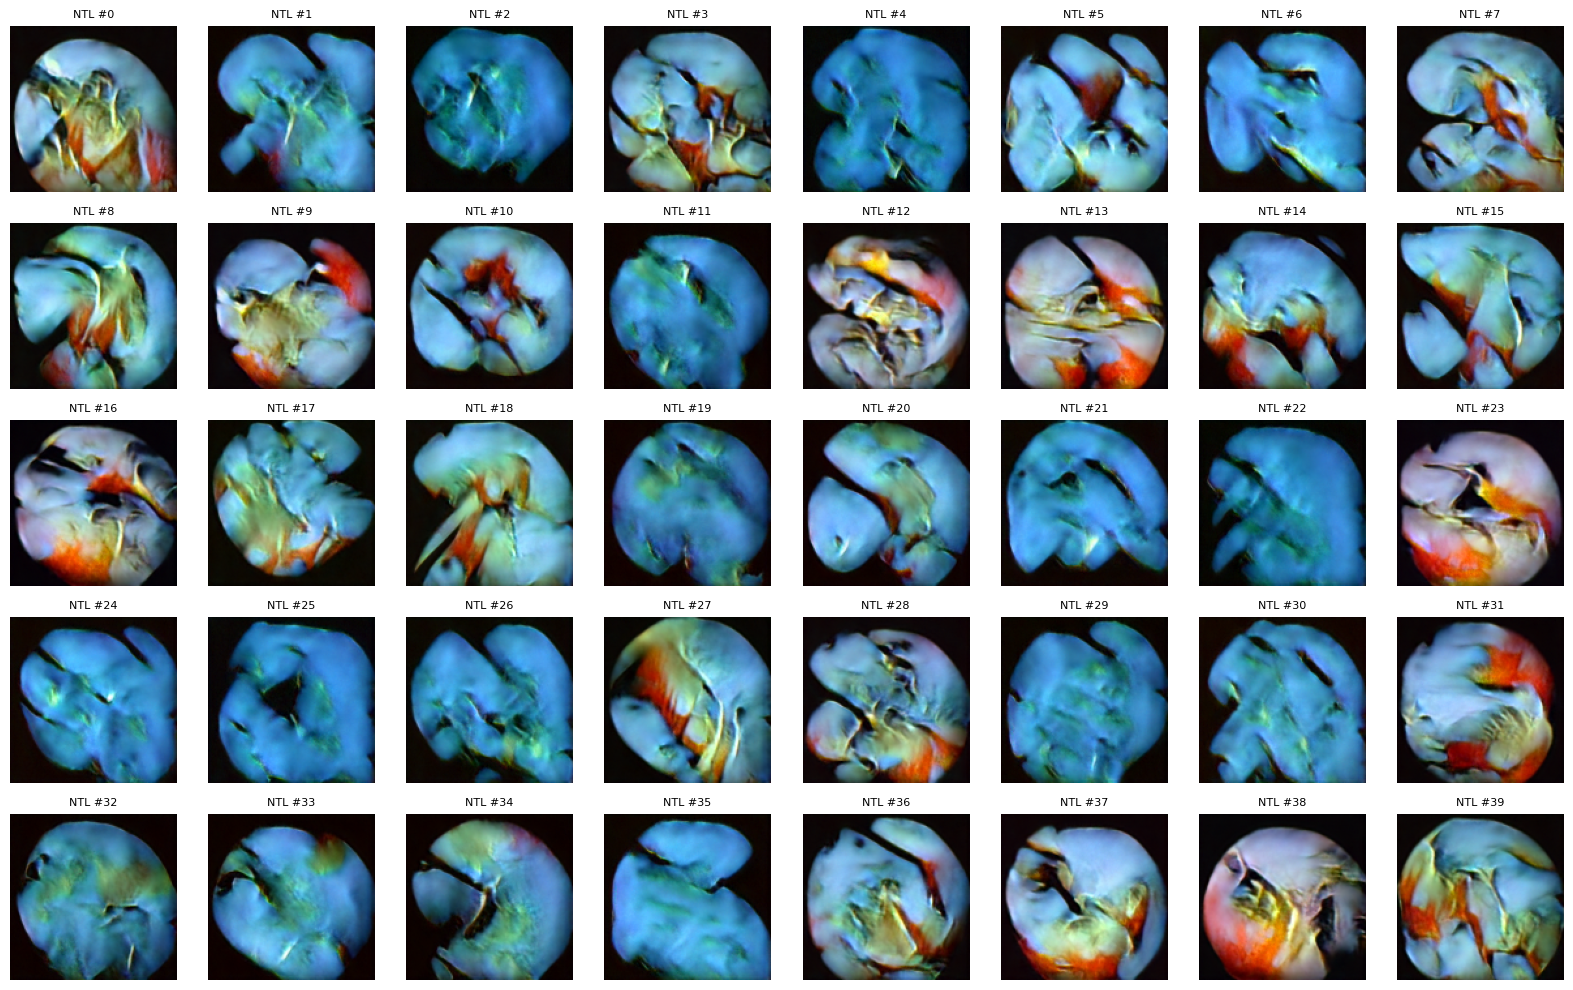

In [11]:
# Display generated images in a grid
fig, axes = plt.subplots(5, 8, figsize=(16, 10))  # 5x8 = 40 images

for i in range(num_samples):
    img = generated_images[i].cpu().permute(1, 2, 0).numpy()
    img = img.clip(0, 1)
    axes[i // 8, i % 8].imshow(img)
    axes[i // 8, i % 8].axis('off')
    axes[i // 8, i % 8].set_title(f'{list(LABEL_MAP.keys())[class_id]} #{i}', fontsize=8)

plt.tight_layout()
plt.savefig('/kaggle/working/generated_samples.png', dpi=150, bbox_inches='tight')
plt.show()

In [12]:
# Save individual generated images
os.makedirs("/kaggle/working/generated_images", exist_ok=True)

from torchvision.utils import save_image
for i, img in enumerate(generated_images):
    save_image(img, f"/kaggle/working/generated_images/{list(LABEL_MAP.keys())[class_id]}_{i:03d}.png")

print(f"Saved {num_samples} images to /kaggle/working/generated_images/")

Saved 40 images to /kaggle/working/generated_images/
